In [342]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from datetime import datetime, timedelta

import optuna
from optuna.integration import OptunaSearchCV

import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

In [343]:
import Billy.forecastingTools as FT
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [344]:
plt.rcParams.update({'figure.figsize': (8, 5), 'figure.dpi': 120})

# 1. EDA

In [345]:
df = pd.read_csv('C:/Users\/juanm/Escritorio/Juanmi/DataFest IKEA/Team 09. ImportBilly/1. Data/visits_train.csv', parse_dates=[1])
df.head()

C:\Users\juanm\AppData\Local\Temp\ipykernel_5176\2388807926.py:1: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv('C:/Users\/juanm/Escritorio/Juanmi/DataFest IKEA/Team 09. ImportBilly/1. Data/visits_train.csv', parse_dates=[1])


,location,date_visit,visits
0,Madrid,2023-02-28,67.323720
1,Madrid,2023-02-27,71.894430
2,Madrid,2023-02-26,87.803810
3,Madrid,2023-02-25,90.435243
4,Madrid,2023-02-24,76.281122


In [346]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   location    1338 non-null   object        
 1   date_visit  1338 non-null   datetime64[ns]
 2   visits      1338 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 31.5+ KB


In [347]:
df.describe()

,date_visit,visits
count,1338,1338.000000
mean,2022-03-31 00:00:00,58.837301
min,2021-05-01 00:00:00,0.000000
25%,2021-10-15 00:00:00,50.429277
50%,2022-03-31 00:00:00,59.213881
75%,2022-09-14 00:00:00,67.605966
max,2023-02-28 00:00:00,101.000000
std,NaN,16.243328


In [348]:
miss_data = pd.isnull(df).values.any()
print("Hay información perdida: ", miss_data, "\n")

sum_miss_data = pd.isnull(df).sum()
print("Hay {} valores perdidos".format(sum_miss_data))

Hay información perdida:  False 

Hay location      0
date_visit    0
visits        0
dtype: int64 valores perdidos


In [349]:
# Duplicates
df.duplicated().value_counts()

False    1338
Name: count, dtype: int64

In [350]:
# Porcentaje de ceros
variables = ['location', 'date_visit', 'visits']
for i in variables:
    df_count=df.loc[df[i] == 0]
    x=(df_count[i].count()/df[i].count())*100
    x=round(x,2)
    print(f'The Number of zero values in column {i} is {x}')

The Number of zero values in column location is 0.0
The Number of zero values in column date_visit is 0.0
The Number of zero values in column visits is 2.62


In [351]:
# Vemos los días que no hay visitas
df[df.visits < 1]

,location,date_visit,visits
53,Madrid,2023-01-06,0.0
734,Barcelona,2022-12-25,0.0
783,Barcelona,2022-11-06,0.0
804,Barcelona,2022-10-16,0.0
818,Barcelona,2022-10-02,0.0
888,Barcelona,2022-07-24,0.0
895,Barcelona,2022-07-17,0.0
902,Barcelona,2022-07-10,0.0
909,Barcelona,2022-07-03,0.0
918,Barcelona,2022-06-24,0.0


Diferenciamos entre Madrid y Barcelona

In [352]:
df_mad = df[df['location']=='Madrid'][['date_visit', 'visits']].reset_index(drop=True)

In [353]:
df_bar = df[df['location']=='Barcelona'][['date_visit', 'visits']].reset_index(drop=True)

Graficamos ambas series temporales

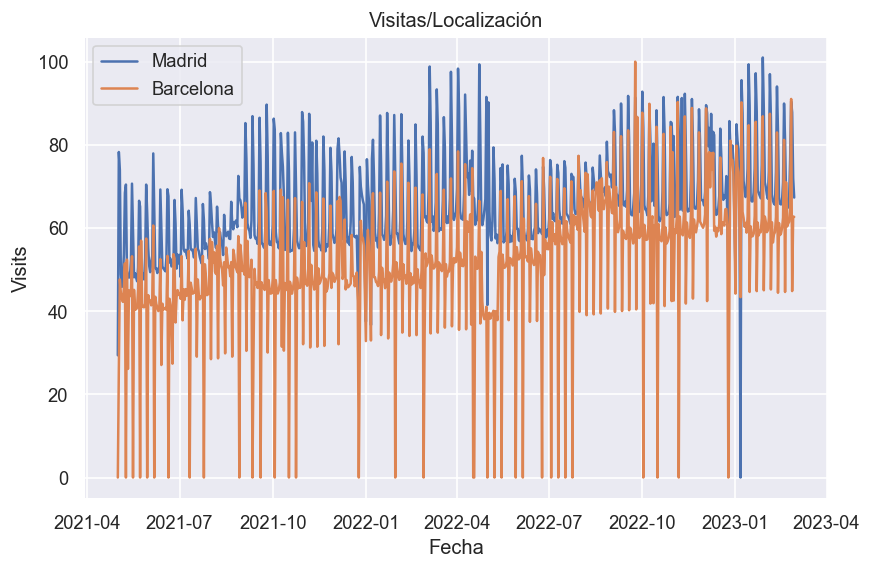

In [354]:
# Graficamos ambas TS
plt.plot(df_mad.date_visit, df_mad['visits'], label='Madrid')
plt.plot(df_bar.date_visit, df_bar['visits'], label='Barcelona')
plt.xlabel('Fecha')
plt.ylabel('Visits')
plt.title('Visitas/Localización')
plt.legend()
plt.show()

Asumiendo que en los datos se tienen en cuenta TODAS las tiendas que pertenecen a cada una de las ciudades, una primera conclusión es que en Barcelona tenemos muchos más días que no acude nadie a las tiendas (tiendas cerradas) ya que Barcelona tiene muchas menos tiendas que Madrid.

# 2.0 Modelo Simple

Para este modelo, vamos a diferenciar entre Madrid y Barcelona, es decir, utilizamos los dataframes df_mad y df_barc

### Madrid

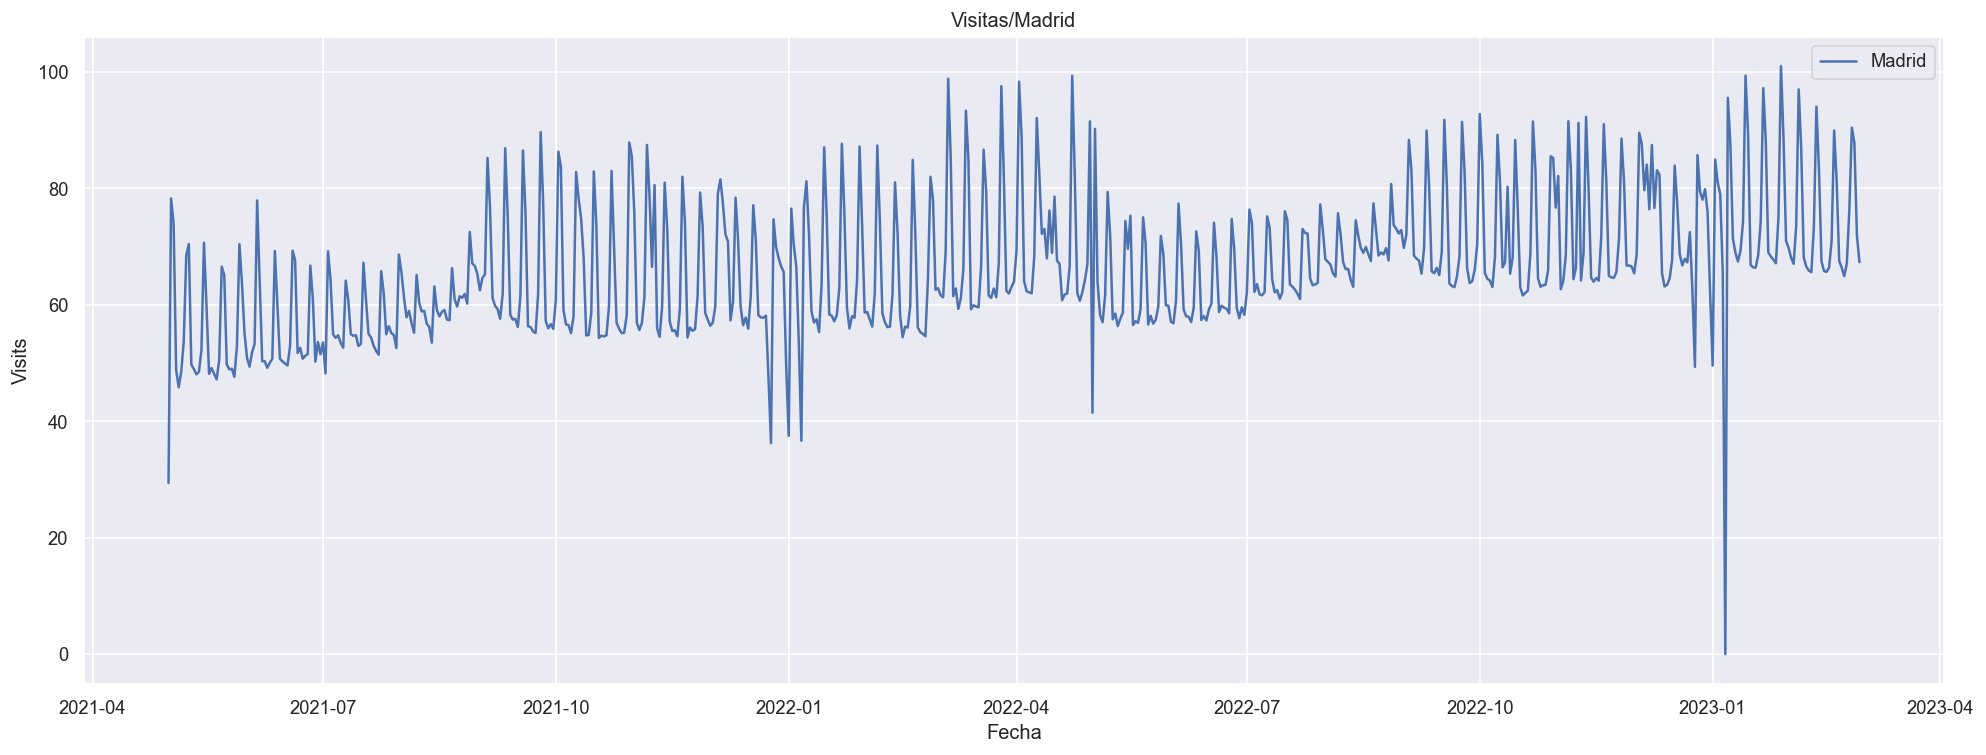

In [355]:
plt.figure(figsize=(20, 7))
plt.plot(df_mad.date_visit, df_mad['visits'], label='Madrid')
plt.xlabel('Fecha')
plt.ylabel('Visits')
plt.title('Visitas/Madrid')
plt.legend()
plt.show()

Comprobamos la si la TS es estacionaria en varianza

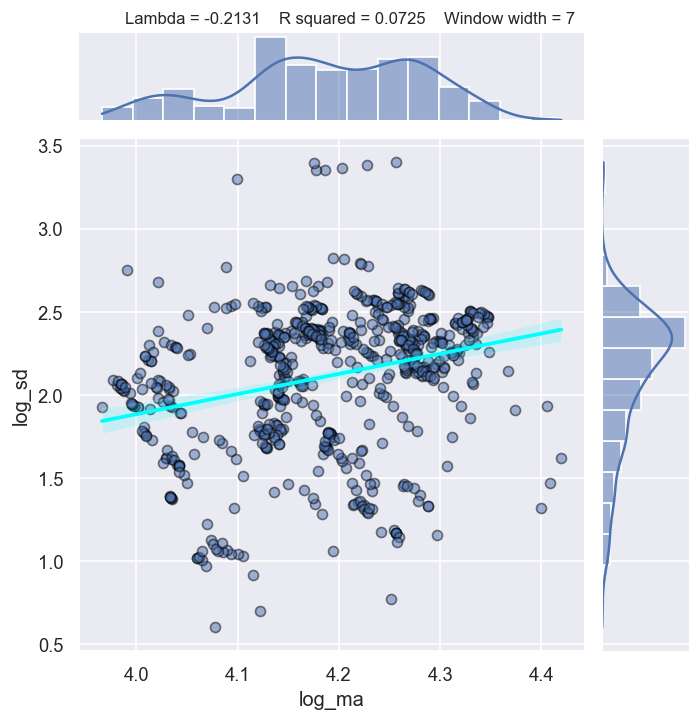

-0.21305507870424178

In [356]:
# Box-Cox transformation
ww = 7
FT.boxcox_lambda_plot(df_mad['visits'], window_width=ww)

Comprobamos que es estacionaria en varianza ya que la desviación típica NO depende del valor medio (MA) y el valor de R_squared es muy bajo, por tanto, NO enemos que realizar una transformación box-cox.

c:\Users\juanm\miniconda3\envs\datafest\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


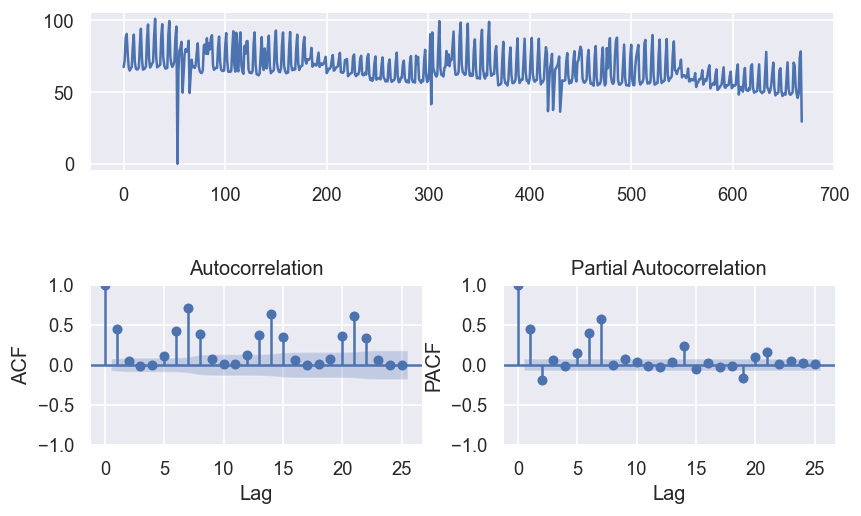

In [357]:
FT.ts_display(df_mad['visits'])

Comprobamos la si la TS es estacionaria en media, para ello, primero vamos a realizar el test de Dicky-Fuller y luego para cerciorarnos vamos a comprobar con los valores de ACF.

In [358]:
# Alternative test - Augmented Dickey Fuller Test
result = adfuller(df_mad['visits'].values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.285161
p-value: 0.635934
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569


Observamos que el p-valor es bastante mayor que 0.05, por tanto, el test de dicky-fuller nos dice que debemos diferenciar regularmente para eliminar la componente tendecial y estabilizar en media a la serie temporal. Para cerciorarnos, observamos los valores de ACF.

c:\Users\juanm\miniconda3\envs\datafest\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


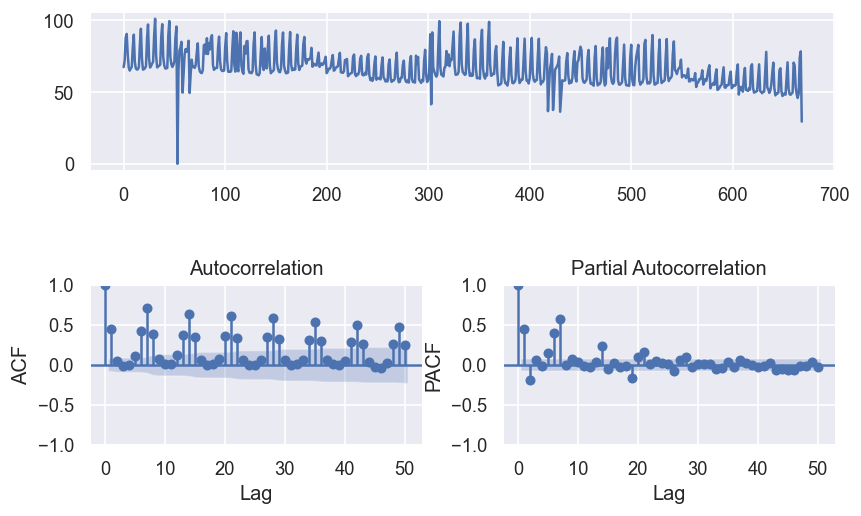

In [359]:
FT.ts_display(df_mad['visits'],lags=50)

En los valores de ACF, vemos que en principio, no necesitamos una diferenciación regular.  
Además, vemos que hay una componente estacional que se repite, por tanto, diferenciamos estacionalmente.

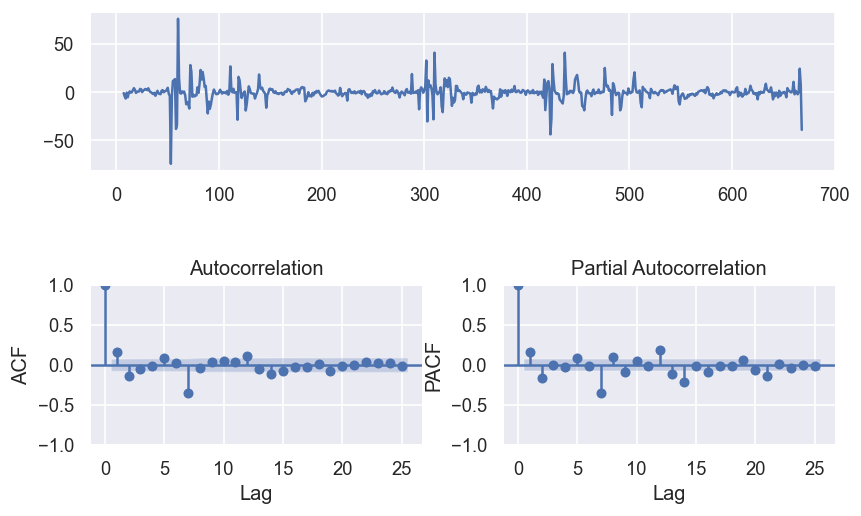

In [360]:
d = 0 #DIferenciación regular; y[t]-y[t-1]. Con eso se quita la 'tendencia gorda'
D = 1 #Diferenciación estacional; y[t]-y[t-s]. Con esto se quita la 'tendencia estacional'
#Es en este momento, con d = 1 y D = 0, donde realmente se ve la tendencia estacional de los datos, al quitar la parte regular.
S = 7 # Seasonality of ww days

Bz = df_mad['visits'].copy()
for diff in range(d):
    Bz = Bz.diff().dropna() # drop first NA value
for seas_diff in range(D):
    Bz = Bz.diff(S).dropna() # drop first NA values
FT.ts_display(Bz)


Vemos que hemos eliminado la componente estacional, por tanto, nuestro primer modelo será:  
    * Parte regular: AR2 o un MA2 -> nos quedamos con AR2 -> (2,0,0)  
    * Parte estacional: AR3 o un MA1 -> nos quedamos con MA1 -> (0,1,1,7)  
Modelo Final -> SARIMA (2,0,0)(0,1,1,7)

c:\Users\juanm\miniconda3\envs\datafest\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\juanm\miniconda3\envs\datafest\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


                                      SARIMAX Results                                      
Dep. Variable:                              visits   No. Observations:                  669
Model:             SARIMAX(2, 0, 0)x(0, 1, [1], 7)   Log Likelihood               -2213.965
Date:                             Sat, 15 Apr 2023   AIC                           4439.931
Time:                                     15:17:18   BIC                           4466.829
Sample:                                          0   HQIC                          4450.361
                                             - 669                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0491      0.150     -0.329      0.742      -0.342       0.244
drift         -0.0005      

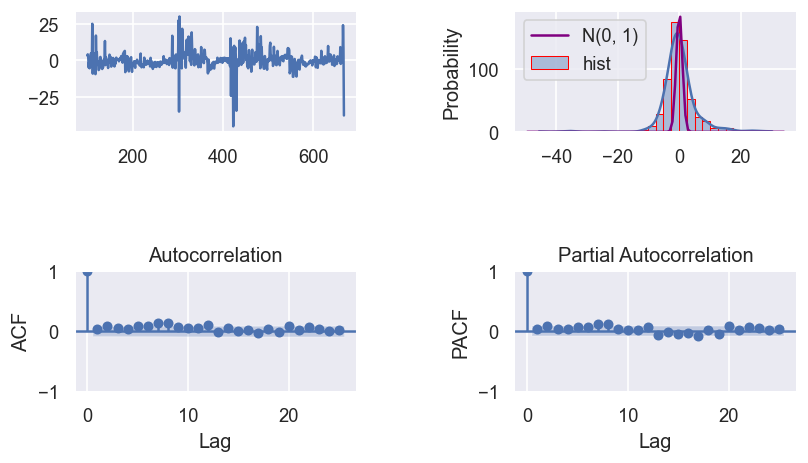

In [361]:
#Se han cambiado el valor del parámetro de diferenciación para que se haga de manera automática, usando el valor seleccionado en la celda anterior.
sarima_fit = SARIMAX(df_mad['visits'], 
                    order=(2,0,0), # Regular components. Para hallar estos valores nos fijamos únicamente en los primeros
                    seasonal_order=(0,1,1,7), # Seasonal components
                    trend= 'ct', # Type of trend: ['c','t','n','ct'] --> [constant, linear, no trend, constant and linear]
                    enforce_invertibility=False, 
                    enforce_stationarity=False).fit()

print(sarima_fit.summary())
FT.check_residuals(pd.DataFrame(sarima_fit.resid.loc[100:]))

Realizamos la predicción y graficamos:

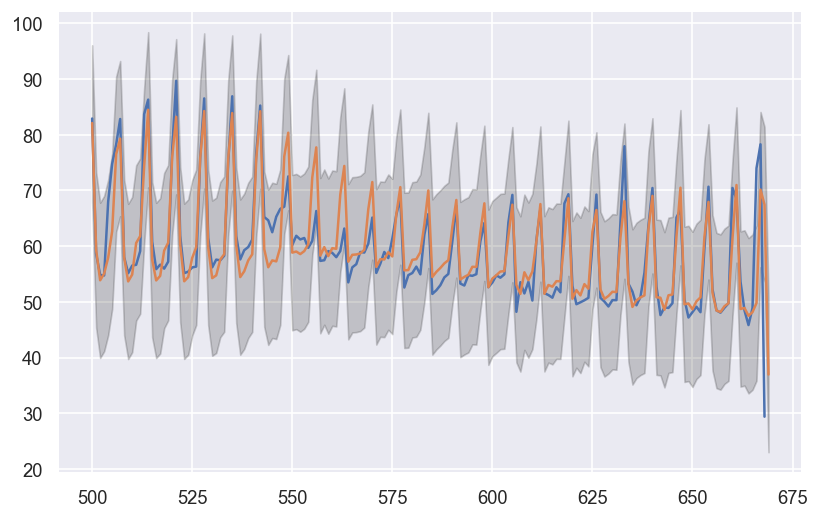

In [362]:
#Obtain forecasts for in-sample and out-of-sample
start = 500
horizon = 0 # que prediga 20 instantes más
end = df_mad['visits'].shape[0] + horizon

pred = sarima_fit.get_prediction(start=start, end= end, dynamic=False)
y_test_pred = pred.predicted_mean
yhat_conf_int = pred.conf_int(alpha=0.05)

plt.figure()
plt.fill_between(yhat_conf_int.index,
                yhat_conf_int.iloc[:, 0],
                yhat_conf_int.iloc[:, 1], color='k', alpha=.2)
plt.plot(df_mad['visits'].loc[start:])
plt.plot(y_test_pred)
plt.show()

In [363]:
# RMSE
rmse_mad = np.sqrt(np.mean((y_test_pred - df_mad['visits'].loc[start:])**2))
print('RMSE mad:', rmse_mad)

RMSE mad: 5.056067924386625


Graficando solo la predicción:

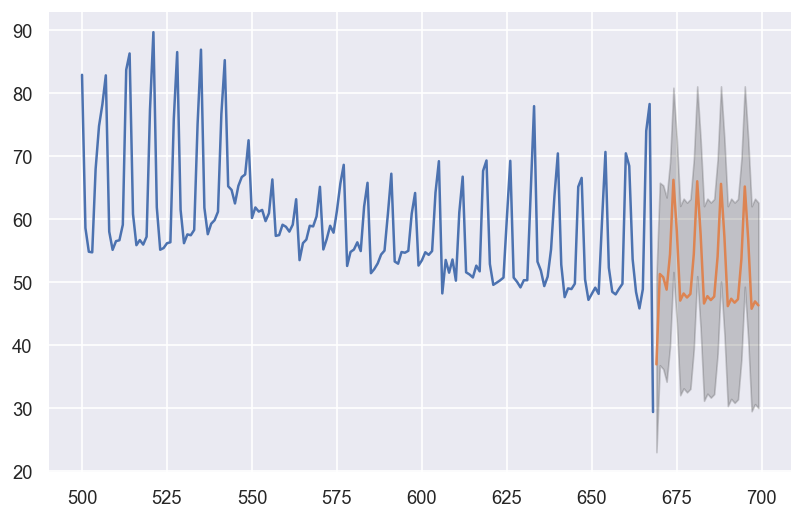

In [364]:
# Plot prediction of out_of_sample and confidence intervals
# If using dynamic = True, the forecast are used as real data
horizon = 31
end = df_mad['visits'].shape[0] + horizon

pred = sarima_fit.get_forecast(steps=horizon, dynamic=False)
y_pred_mad = pred.predicted_mean
yhat_conf_int = pred.conf_int(alpha=0.05)


plt.figure()
plt.fill_between(yhat_conf_int.index,
                yhat_conf_int.iloc[:, 0],
                yhat_conf_int.iloc[:, 1], color='k', alpha=.2)
plt.plot(df_mad['visits'].loc[start:])
plt.plot(y_pred_mad)
plt.show()

### Barcelona

Realizamos el mismo proceso que en el caso de madrid

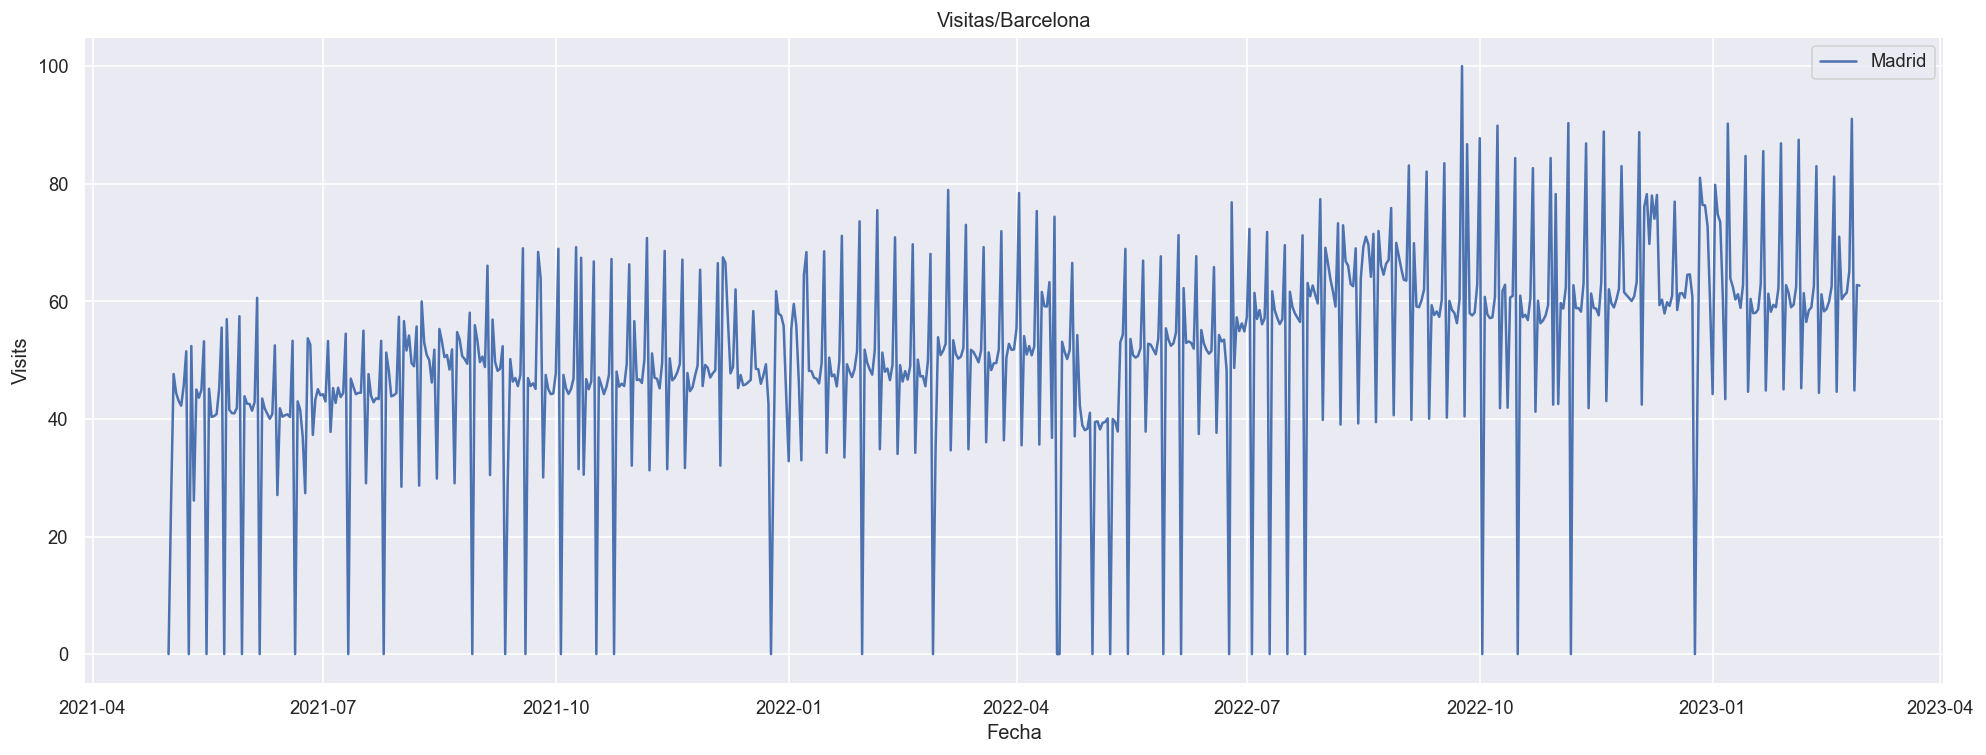

In [365]:
plt.figure(figsize=(20, 7))
plt.plot(df_bar.date_visit, df_bar['visits'], label='Madrid')
plt.xlabel('Fecha')
plt.ylabel('Visits')
plt.title('Visitas/Barcelona')
plt.legend()
plt.show()

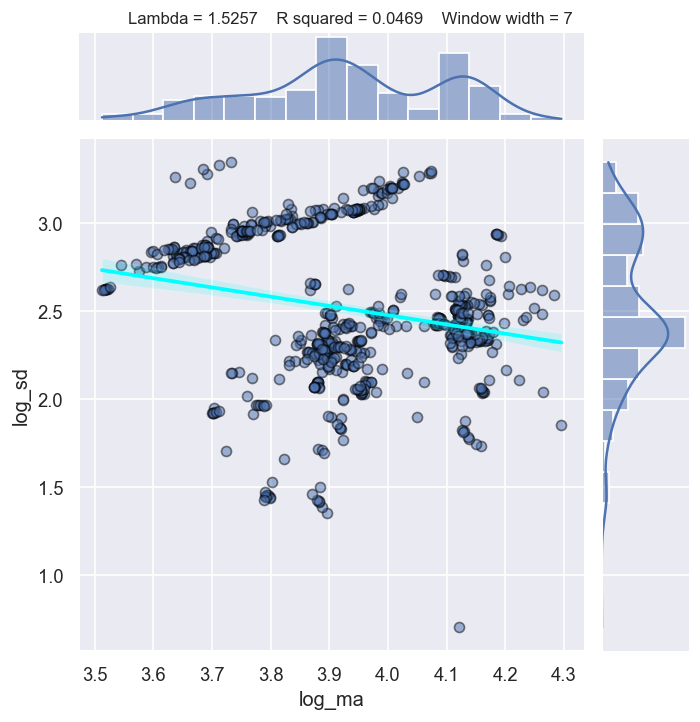

1.5256872094993716

In [366]:
# Box-Cox transformation
FT.boxcox_lambda_plot(df_bar['visits'], window_width=7)

TS estacionaria en varianza

c:\Users\juanm\miniconda3\envs\datafest\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


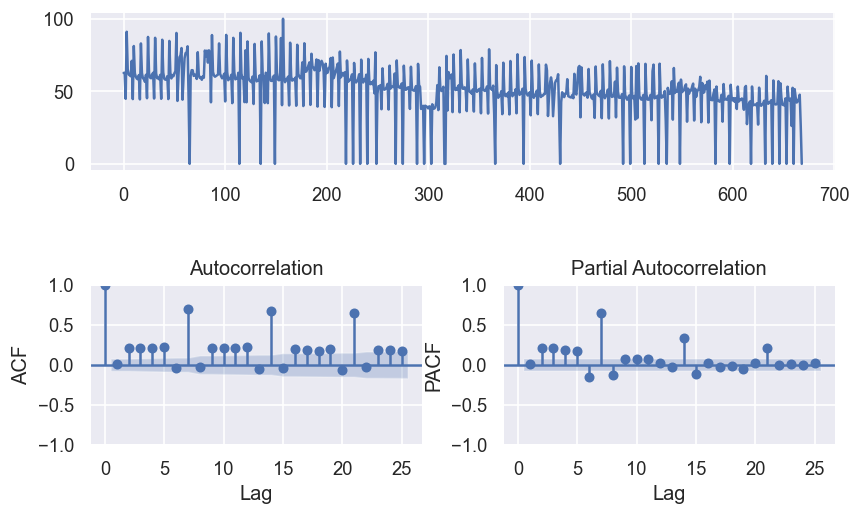

In [367]:
FT.ts_display(df_bar['visits'])

Dicky-Fuller:

In [368]:
# Alternative test - Augmented Dickey Fuller Test
result = adfuller(df_bar['visits'].values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.305618
p-value: 0.626598
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569


Comprobamos en ACF:

c:\Users\juanm\miniconda3\envs\datafest\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


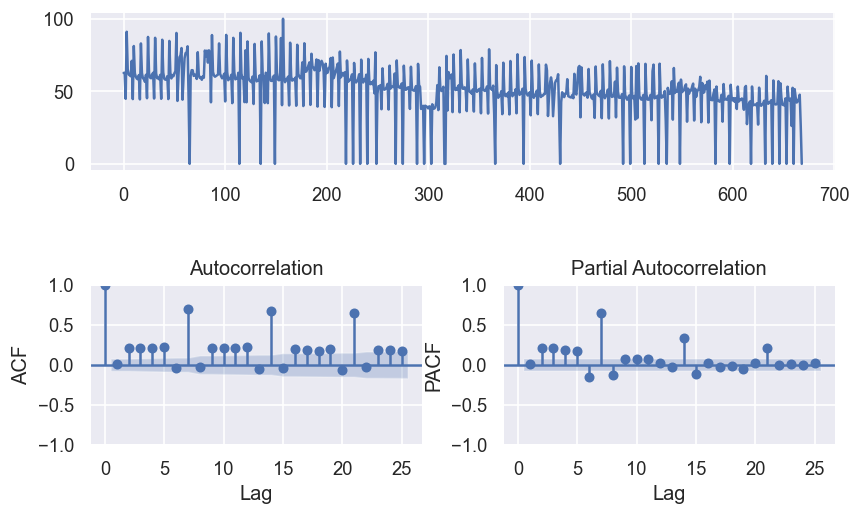

In [369]:
FT.ts_display(df_bar['visits'])

En los valores de ACF, vemos que en principio, no necesitamos una diferenciación regular.  
Además, vemos que hay una componente estacional que se repite, por tanto, diferenciamos estacionalmente.

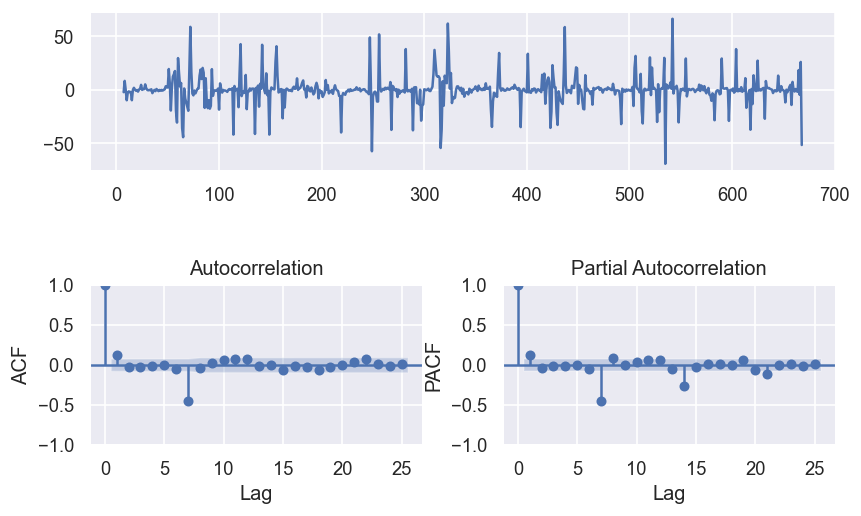

In [370]:
d = 0 #DIferenciación regular; y[t]-y[t-1]. Con eso se quita la 'tendencia gorda'
D = 1 #Diferenciación estacional; y[t]-y[t-s]. Con esto se quita la 'tendencia estacional'
#Es en este momento, con d = 1 y D = 0, donde realmente se ve la tendencia estacional de los datos, al quitar la parte regular.
S = 7 # Seasonality of ww days

Bz = df_bar['visits'].copy()
for diff in range(d):
    Bz = Bz.diff().dropna() # drop first NA value
for seas_diff in range(D):
    Bz = Bz.diff(S).dropna() # drop first NA values
FT.ts_display(Bz)

Vemos que hemos eliminado la componente estacional, por tanto, nuestro primer modelo será:  
    * Parte regular: AR1 o un MA1 -> nos quedamos con AR1 -> (1,0,0)  
    * Parte estacional: AR3 o un MA1 -> nos quedamos con MA1 -> (0,1,1,7)  
Modelo Final -> SARIMA (1,0,0)(0,1,1,7)

                                      SARIMAX Results                                      
Dep. Variable:                              visits   No. Observations:                  669
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 7)   Log Likelihood               -2481.094
Date:                             Sat, 15 Apr 2023   AIC                           4972.189
Time:                                     15:17:22   BIC                           4994.604
Sample:                                          0   HQIC                          4980.881
                                             - 669                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.1382      0.254     -0.545      0.586      -0.635       0.359
drift         -0.0003      

c:\Users\juanm\miniconda3\envs\datafest\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


Ljung-Box test of residuals:
      lb_stat  lb_pvalue
25  34.249869   0.102674


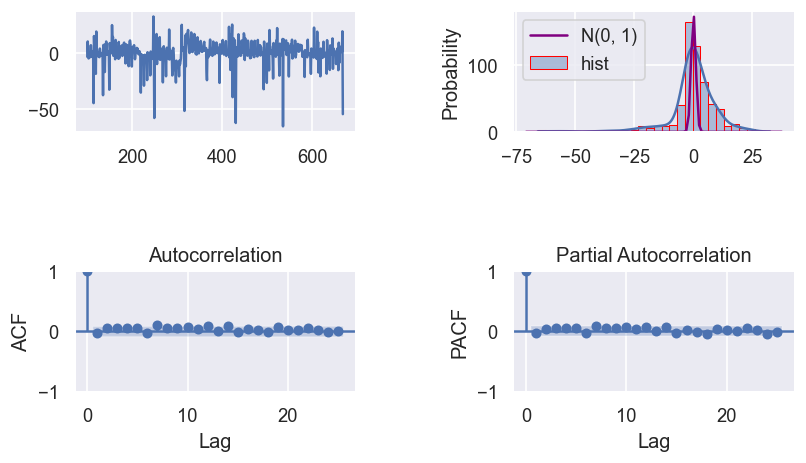

In [371]:
#Se han cambiado el valor del parámetro de diferenciación para que se haga de manera automática, usando el valor seleccionado en la celda anterior.
sarima_fit = SARIMAX(df_bar['visits'], 
                    order=(1,0,0), # Regular components. Para hallar estos valores nos fijamos únicamente en los primeros
                    seasonal_order=(0,1,1,7), # Seasonal components
                    trend= 'ct', # Type of trend: ['c','t','n','ct'] --> [constant, linear, no trend, constant and linear]
                    enforce_invertibility=False, 
                    enforce_stationarity=False).fit()

print(sarima_fit.summary())
FT.check_residuals(pd.DataFrame(sarima_fit.resid.loc[100:]))

Realizamos la predicción y graficamos:

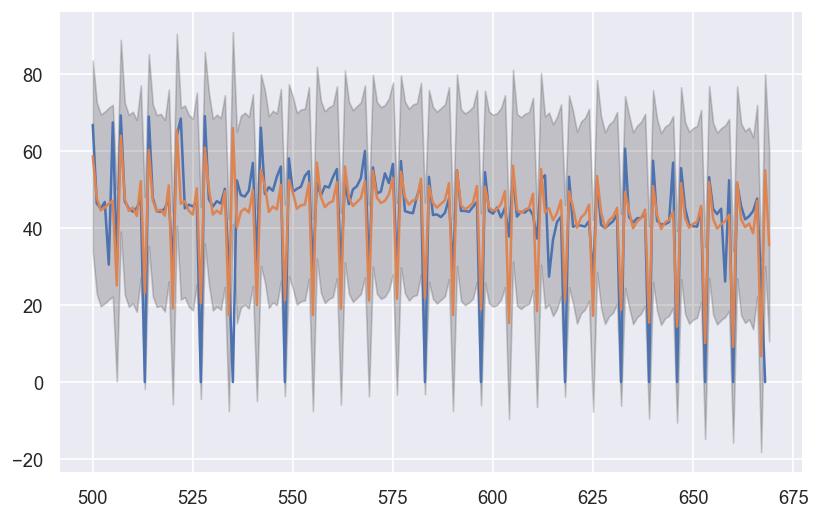

In [372]:
#Obtain forecasts for in-sample and out-of-sample
start = 500
horizon = 0 # que prediga 20 instantes más
end = df_bar['visits'].shape[0] + horizon

pred = sarima_fit.get_prediction(start=start, end= end, dynamic=False)
y_test_pred = pred.predicted_mean
yhat_conf_int = pred.conf_int(alpha=0.05)

plt.figure()
plt.fill_between(yhat_conf_int.index,
                yhat_conf_int.iloc[:, 0],
                yhat_conf_int.iloc[:, 1], color='k', alpha=.2)
plt.plot(df_bar['visits'].loc[start:])
plt.plot(y_test_pred)
plt.show()

In [373]:
# RMSE
rmse_bar = np.sqrt(np.mean((y_test_pred - df_bar['visits'].loc[start:])**2))
print('RMSE bar:', rmse_bar)

RMSE bar: 10.133738763596126


Graficando solo la predicción:

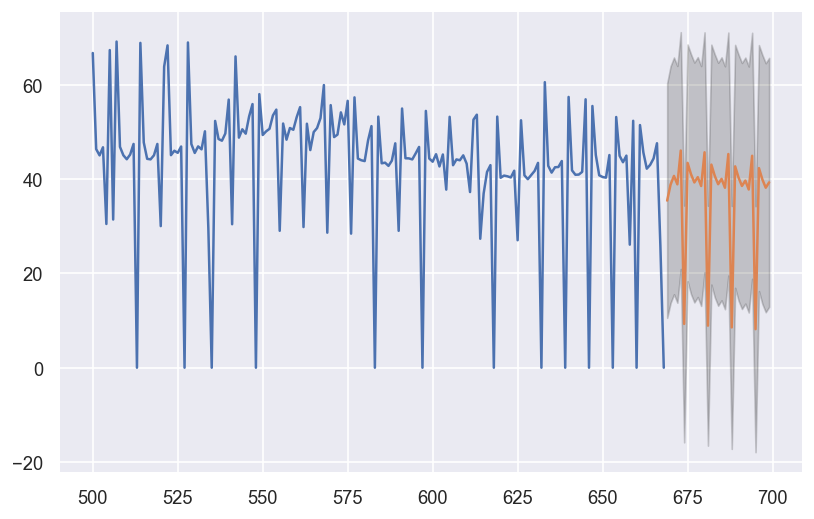

In [374]:
# Plot prediction of out_of_sample and confidence intervals
# If using dynamic = True, the forecast are used as real data
horizon = 31
end = df_bar['visits'].shape[0] + horizon

pred = sarima_fit.get_forecast(steps=horizon, dynamic=False)
y_pred_bar = pred.predicted_mean
yhat_conf_int = pred.conf_int(alpha=0.05)


plt.figure()
plt.fill_between(yhat_conf_int.index,
                yhat_conf_int.iloc[:, 0],
                yhat_conf_int.iloc[:, 1], color='k', alpha=.2)
plt.plot(df_bar['visits'].loc[start:])
plt.plot(y_pred_bar)
plt.show()

### Unimos predicciones

Fechas

In [375]:
# Crea un rango de fechas para marzo de 2023
start_date = datetime(2023, 3, 1)
end_date = datetime(2023, 4, 1) - timedelta(days=1)
date_range = pd.date_range(start_date, end_date)

# Convierte el rango de fechas en una lista de cadenas con formato 'yyyy-mm-dd'
date_list = [date.strftime('%Y-%m-%d') for date in date_range]


In [376]:
# Forecast df
df_frcst_sarima = pd.DataFrame(columns=['location_date', 'visits'])

In [377]:
frcst_bar = pd.DataFrame({'location_date': date_list, 'visits':y_pred_bar}).reset_index(drop=True)
frcst_mad = pd.DataFrame({'location_date': date_list, 'visits':y_pred_mad}).reset_index(drop=True)
frcst_bar['location_date'] = 'Barcelona_' +  frcst_bar['location_date']
frcst_mad['location_date'] = 'Madrid_' +  frcst_mad['location_date']

In [378]:
df_frcst_sarima = pd.concat([frcst_bar, frcst_mad], axis=0).reset_index(drop=True)

In [379]:
df_frcst_sarima.to_csv('sarima_frcst.csv', index = False)